<img src="img/banner.PNG" align="center">

In [309]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [310]:
%matplotlib notebook

## Impulse Responses for Ideal Filters

In [311]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [312]:
# Other supporting functions

def db(x):
    # db of magnitude, excludes divide by zero errors
    np.where(x < np.finfo(np.float64).eps, np.finfo(np.float64).eps, x)
    return 20 * np.log10(np.abs(x))

def enbw(win):
    # computes the equivalent noise bandwidth for a window in units of bins
    return len(win) * np.sum(win**2) / (np.sum(win))**2

In [345]:
# Impulse responses

def lowpass(fc, N):
    # fc: frequency cutoff between 0 and 0.5 (normalized frequency with fs=1)
    # N: Number of coefficients, can be even or odd
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return 2 * fc * np.sinc(2*fc*n)

def highpass(fc, N):
    # fc: frequency cutoff between 0 and 0.5 (normalized frequency with fs=1)
    # N: Number of coefficients, must be odd only
    if N%2-1:
        #even
        raise ValueError("N must be odd")
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return lowpass(0.5-fc, N) * (-1)**n

def bandpass(f1, f2, N):
    # f1: frequency cutoff between 0 and 0.5 of lower cutoff (normalized frequency with fs=1)
    # f2: frequency cutoff between 0 and 0.5 of upper cutoff (normalized frequency with fs=1)
    # N: Number of coefficients
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return 2 * f2 * np.sinc(2*f2*n) - 2 * f1 * np.sinc(2*f1*n)

def bandstop(f1, f2, N):
    # f1: frequency cutoff between 0 and 0.5 of lower cutoff (normalized frequency with fs=1)
    # f2: frequency cutoff between 0 and 0.5 of upper cutoff (normalized frequency with fs=1)
    # N: Number of coefficients, must be odd only
    if N%2-1:
        #even
        raise ValueError("N must be odd")
    n = np.arange(-(N-1)/2,(N-1)/2 + 1)
    return np.where(n==0, 1- 2 * (f2 - f1), 2*f1 * np.sinc(2*f1*n)  - 2*f2 * np.sinc(2*f2*n))

<IPython.core.display.Javascript object>


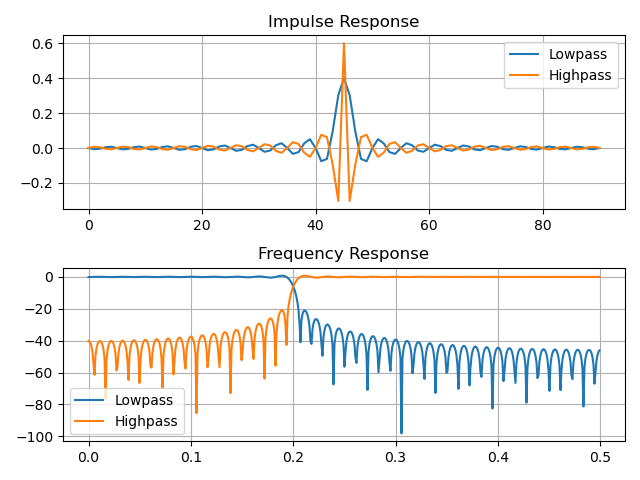

<IPython.core.display.Javascript object>


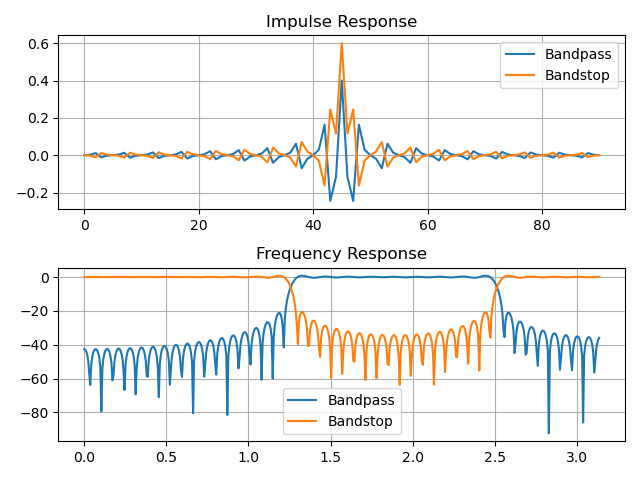

In [532]:
N =91
fc = 0.2
f1 = 0.2
f2 = 0.4

plt.figure()
plt.subplot(2,1,1)
plt.title("Impulse Response")
plt.plot(lowpass(fc, N), label="Lowpass")
plt.plot(highpass(fc, N), label="Highpass")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
wlp, hlp = sig.freqz(lowpass(fc, N))
whp, hhp = sig.freqz(highpass(fc, N))
plt.title("Frequency Response")
plt.plot(wlp/(2*np.pi), db(hlp), label="Lowpass")
plt.plot(whp/(2*np.pi), db(hhp), label="Highpass")
plt.legend()
plt.grid()
plt.tight_layout()

plt.figure()
plt.subplot(2,1,1)
plt.title("Impulse Response")
plt.plot(bandpass(f1,f2,N), label="Bandpass")
plt.plot(bandstop(f1,f2,N), label="Bandstop")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
wbs, hbs = sig.freqz(bandstop(f1,f2, N))
wbp, hbp = sig.freqz(bandpass(f1,f2, N))
plt.title("Frequency Response")
plt.plot(wbp, db(hbp), label="Bandpass")
plt.plot(wbs, db(hbs), label="Bandstop")
plt.legend()
plt.grid()
plt.tight_layout()

## Windowing Method for FIR Design

The windowing method is to select a finite portion of the ideal infinite duration impulse response using a window to taper the edges of the impulse response such as to miminize spectral leakage, resulting in superior stopband rejection and passband ripple at the expense of an increase in the transition band (which is always a good trade; the overall length can be increased to achieve the transition band desired, but without additional windowing, many stopband requirements cannot be practically met.

Note this can be done using the impulse response functions above, or directly using scipy.firwin and scipy.firwin2. 

This method is computationally cheap, and with a Kaiser window comes close to the performance of a filter designed with the optimized Least Squares algorithm (see direct comparison below). Typically, the least squares algorithm would be used when resources for computing the filter coefficients are not an issue. However, this approach is to be considered when filter coefficients are dynamically determined, or in conditions when the least squares algorithm has difficulty converging. 

The following demonstrates the Windowing Method for a low pass filter with the following requirements:

* Passband ripple: ±0.2 dB
* Stopband rejection: -33 dB
* Sampling rate: 48 KHz
* Passband edge: 9.6 KHz
* Stopband edge: 12 KHz


In [563]:
pass_ripp = 0.2        # passband ripple [+/- dB]
stop_rej = -83         # stopband rejection [dB]
fs = 48e3              # sampling rate [Hz]
passband = 9600        # passband edge [Hz]
stopband = 12000       # stopband edge [Hz]

fpass = passband/fs    # normalized passband frequency [cycles/sample]
fstop = stopband/fs    # normalized stopband frequency [cylces/sample]


# Estimating number of taps needed and window beta using the built-in kaiserord function
# Note that kaiserord function wants input frequencies normalized to Nyquist (fs/2 = 1)

# Use more restrictive between pass_rip and stop_rej 
delta1 = 10**(pass_ripp/20)-1
delta2 = 10**(stop_rej/20)
print(f"Passband ripple is {delta1:0.3f} and stopband ripple is {delta2:0.3f}")
if delta1 > delta2:
    ripple = -20 * np.log10(delta2)
    print("Using stopband ripple as ripple requirement.")
else:
    ripple = -20 * np.log10(delta1)
    print("Using passband ripple as ripple requirement.")

# (Ripple is a positve dB number)
numtaps, beta = sig.kaiserord(ripple, 2*(fstop-fpass))

print(f"Estimated number of coefficients required: {numtaps:d}")
print(f"Estimated Kaiser window beta required: {beta:0.2f}")

Passband ripple is 0.023 and stopband ripple is 0.000
Using stopband ripple as ripple requirement.
Estimated number of coefficients required: 106
Estimated Kaiser window beta required: 8.19


<IPython.core.display.Javascript object>


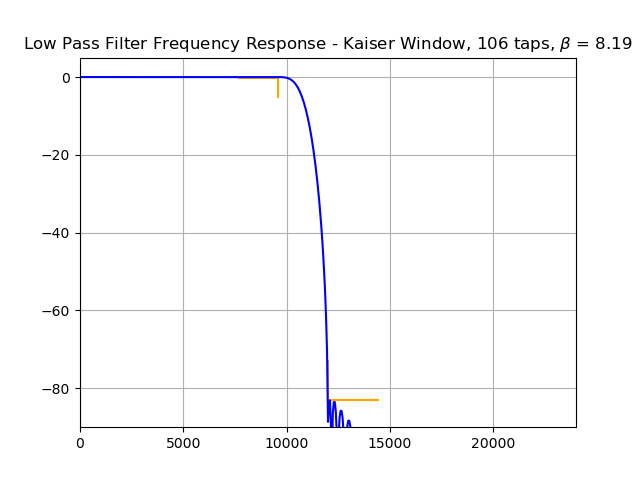

In [564]:
# First we will demonstrate window method directly as a windowed ideal impulse response
# and then we will compare to uisng the firwin command directly


# create ideal impulse response, 

# compute target 6 dB cutoff: (approx 0.025 cycles/sample higher than fpass)

fco = fpass + 0.025

# windowing method will map fpass to -6 dB cutoff

impulse_response = lowpass(fpass + 0.02567, numtaps)
impulse_response = lowpass(fpass + 0.025, numtaps)
#impulse_response = lowpass(fco, numtaps)
# multiply with a Kaiser window
coeff = impulse_response * sig.kaiser(numtaps, beta)

# plot spectrum (made a function as will do this repetitively)

def plotfilt(coeff, passband, stopband, pass_ripp, stop_rej, label="", color='blue'):
    w, h = sig.freqz(coeff)

    # plot requirement markers
    plt.plot([stopband, stopband*1.2], [stop_rej, stop_rej], color='orange')
    plt.plot([stopband, stopband], [stop_rej, stop_rej+10], color='orange')
    plt.plot([passband*.8, passband], [-pass_ripp, -pass_ripp], color='orange')
    plt.plot([passband, passband], [-pass_ripp, -pass_ripp-5], color='orange')
    # plot response
    plt.plot(w * fs/(2*np.pi), db(h), label=label, color=color)
    plt.grid()
    
plt.figure()
plotfilt(coeff, passband, stopband, pass_ripp, stop_rej)
plt.axis([0, fs/2, -90,5])
__=plt.title(fr"Low Pass Filter Frequency Response - Kaiser Window, {numtaps} taps, $\beta$ = {beta:0.2f}")


<IPython.core.display.Javascript object>


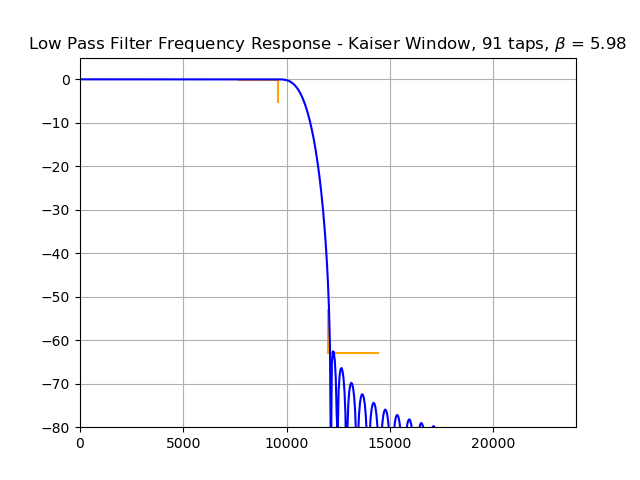

In [559]:
# Showing that firwin returns the same result as windowing the impulse response with the kaiser window:
# (Note that we again increase the passband by approx 12.5% for this case, otherwise passband will be the 
# -6 dB cutoff frequency)
# fco * fs since this function is taking freq in Hz given nyq=0.5*fs, and fco is in normalized freq units of cycles/sample
coeff2 = sig.firwin(numtaps, fco * fs, window=('kaiser', beta), scale=False, nyq=0.5*fs)

plt.figure()
plotfilt(coeff2, passband, stopband, pass_ripp, stop_rej)
plt.axis([0, fs/2, -80,5])
__=plt.title(fr"Low Pass Filter Frequency Response - Kaiser Window, {N} taps, $\beta$ = {beta:0.2f}")


## Optimized Filter Design Algorithms

The optimized algorithms are superior to window design approaches for achieving minimum error with the least number of coefficients. For an optimum solution in the minimax sense (minimize the peak error), we will use the **scipy.signal.remez** function for the Parks-McClellan filter design algorithm (which used the Remez exchange algorithm specific to filter design). For an optimum solution in the least squares sense we will use the **scipy.signal.firls** function. These will then be compared to the Kaiser Window result above with the least number of taps to meet the design requirement.   

In [199]:
# Estimating the number of taps using fred harris' estimator:

ntaps = -stop_rej / (22 * (fstop-fpass))
print(f"Estimated number of coefficients required using fred harris estimator: {int(ntaps):d}")

Estimated number of coefficients required using fred harris estimator: 30


<IPython.core.display.Javascript object>


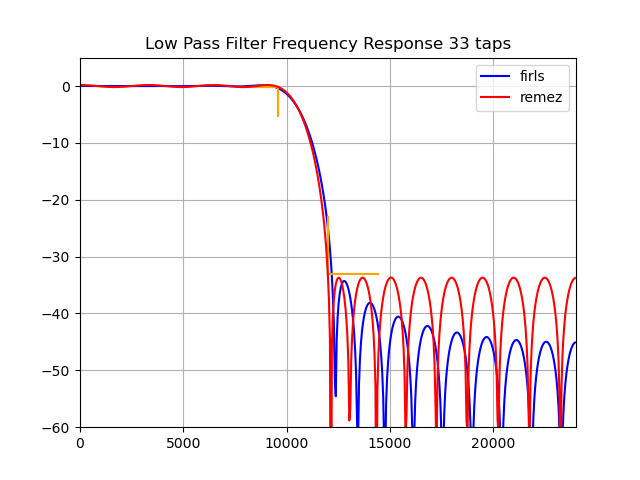

In [232]:
# the firls function requires N to be odd, so increased to next odd number that met target requirement
ntaps = 33
# by setting the optional fs we can pass in actual instead of normalized frequency:
coeff_ls = sig.firls(ntaps, [0, passband, stopband, fs/2], [1,1,0,0], fs=fs)
coeff_pm = sig.remez(ntaps, [0, passband, stopband, fs/2], [1, 0] , fs=fs)
plt.figure()
plotfilt(coeff_ls, passband, stopband, pass_ripp, stop_rej, label="firls", color="blue")
plotfilt(coeff_pm, passband, stopband, pass_ripp, stop_rej, label="remez", color="red")

plt.axis([0, fs/2, -60,5])
plt.grid()
__=plt.title(fr"Low Pass Filter Frequency Response {ntaps} taps")
plt.legend()

## Comparison Plot


<IPython.core.display.Javascript object>


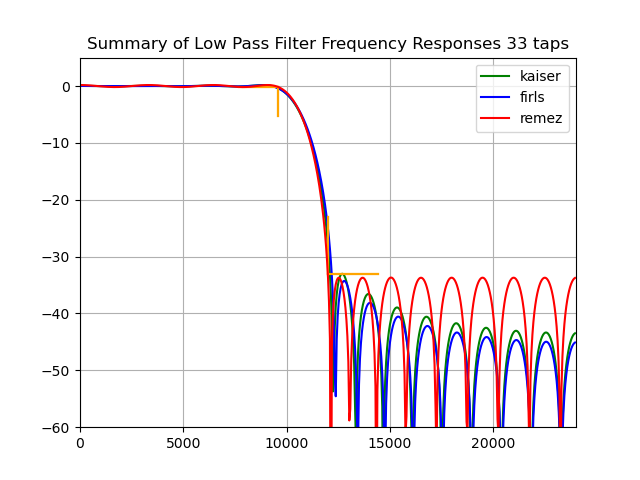

In [229]:
# create Kaiser windowed filter with same number of taps for direct comparison:

coeff_kais = sig.firwin(ntaps, passband * 1.125, window=('kaiser', beta), scale=False, nyq=0.5*fs)

plt.figure()
plotfilt(coeff_kais, passband, stopband, pass_ripp, stop_rej, label="kaiser", color="green")
plotfilt(coeff_ls, passband, stopband, pass_ripp, stop_rej, label="firls", color="blue")
plotfilt(coeff_pm, passband, stopband, pass_ripp, stop_rej, label="remez", color="red")

plt.axis([0, fs/2, -60,5])
plt.grid()
__=plt.title(fr"Summary of Low Pass Filter Frequency Responses {ntaps} taps")
plt.grid()
plt.legend()

firstnull_bins=1.6189931866062328
firstnull_freq=0.016189931866062327
firstnull_index=2122


<IPython.core.display.Javascript object>


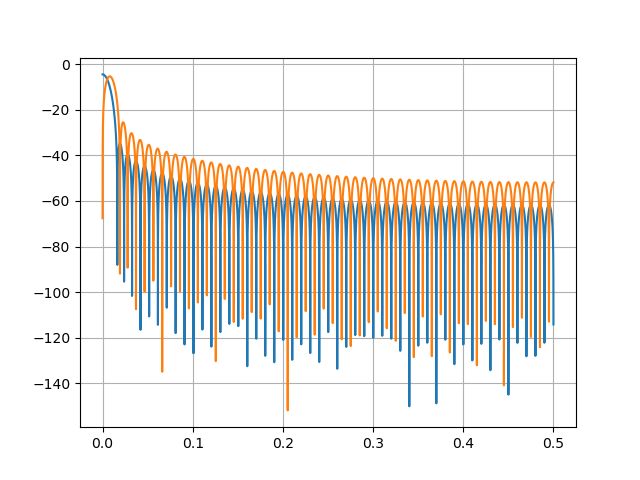

-0.06255758532643085
derivative at first null is -0.14737556560609164


In [503]:
# Derivative of Kaiser window Kernel in proximity of first zero crossing
length= 100
nsamps = 2**16
beta = 4
firstnull_bins = np.sqrt(1+ (beta/np.pi)**2)
firstnull_freq = firstnull_bins / length
firstnull_index = int( np.round(2 *firstnull_bins /length * nsamps))

print(f"{firstnull_bins=}")
print(f"{firstnull_freq=}")
print(f"{firstnull_index=}")
win = sig.kaiser(length, beta)
w, fwin = sig.freqz(win, length, worN = nsamps) 
# rotate to real axis
fwin2 = np.real(fwin * np.exp(1j * 2*np.pi * length/4.0405 * np.arange(nsamps)/nsamps))



#approximate derivative as differences 
plt.figure()
dfwin = np.diff(fwin2) * 2 * nsamps/length
plt.plot(w/(2*np.pi), db(fwin2))
plt.plot(w[1:]/(2*np.pi), db(dfwin))
print((fwin2[2]-fwin2[1])*nsamps)
#plt.plot(w[1:]/(2*np.pi) - 1/(2*length) , db(dfwin))
plt.grid()

print(f"derivative at first null is {dfwin[firstnull_index]}")


<IPython.core.display.Javascript object>


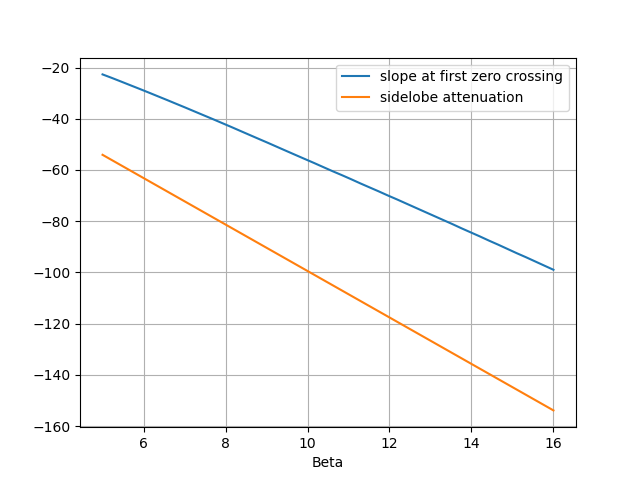

In [531]:
# sweep beta and get derivative of first null at zero crossing:

betas = np.linspace(5,16,50)
derivatives = []
attens = []
for beta in betas:
    firstnull_bins = np.sqrt(1+ (beta/np.pi)**2)
    firstnull_index = int( np.round(2 *firstnull_bins /length * nsamps))
    
    win = sig.kaiser(length, beta)
    w, fwin = sig.freqz(win, length, worN = nsamps) 
    # rotate to real axis
    fwin2 = np.real(fwin * np.exp(1j * 2*np.pi * length/4.0405 * np.arange(nsamps)/nsamps))
    dfwin = np.diff(fwin2) * 2 * nsamps/length
    derivative = dfwin[firstnull_index]
    #derivative = fwin2[firstnull_index+1]-fwin2[firstnull_index-1]  *  nsamps/length
    derivatives.append(derivative)
    
    a1 = beta/.1102 + 8.7
    attens.append(-a1)
    
    
plt.figure()
plt.plot(betas, 20*np.log10(np.abs(derivatives)), label="slope at first zero crossing")
plt.plot(betas, attens, label="sidelobe attenuation")
plt.grid()
plt.xlabel("Beta")
plt.legend()

In [527]:
## TO DO: extend above to instead compare Beta vs Sidelobe attenuation (delta2) and offset needed to shift fpass
# (distance from first zero crossing which we can compute to where transition band crosses sidelobe level)
# From that I can determine and approximating equation for offset based on delta2

7.85726

<IPython.core.display.Javascript object>


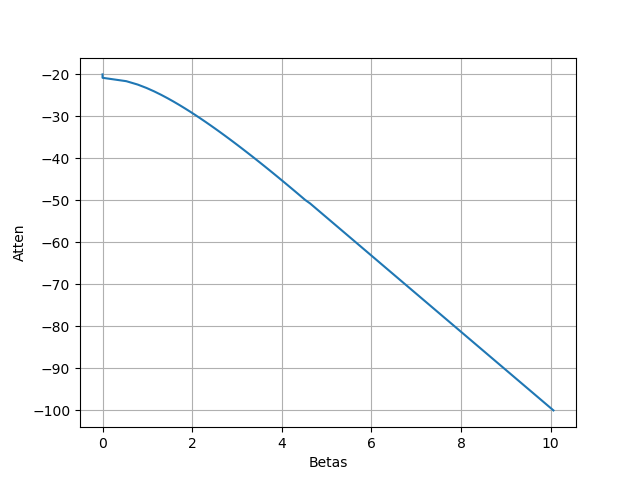

<IPython.core.display.Javascript object>


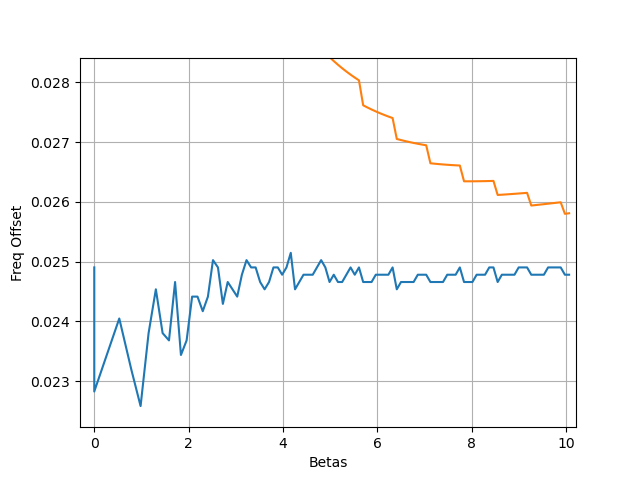

In [551]:
# sweep a (attenuation) from 20 to 100 and determine betas since we can use Kaiser's functions for that

# then compute the freq response and find the offset from fc:

attens = np.linspace(20,100,100)
betas = []
freqs= []
nulls  = []
fco = 0.25


#example run

##atten = 40
##numtaps, beta = sig.kaiserord(atten, 2*(fstop-fpass))
##coeff = sig.firwin(numtaps, fco, window=('kaiser', beta), scale=False, nyq=0.5)
##w, h = sig.freqz(coeff, worN = 2**16)
##plt.plot()

for atten in attens:
    numtaps, beta = sig.kaiserord(atten, 2*(fstop-fpass))
    coeff = sig.firwin(numtaps, fco, window=('kaiser', beta), scale=False, nyq=0.5)
    w, h = sig.freqz(coeff, worN = 2**12)
    lastfind = 1
    betas.append(beta)
    nulls.append(np.sqrt(1+(beta/np.pi)**2)/numtaps)
    for freq, resp in zip(w/(2*np.pi),h):
        find = abs(resp)- 10**(-atten/20)
        if find<0:
            freqs.append(lastfreq)
            break
        else:
            lastfreq = freq
plt.figure()            
plt.plot(betas, -attens)

plt.xlabel("Betas")
plt.ylabel("Atten")
plt.grid()

plt.figure()
plt.plot(betas, np.array(freqs)-fco)
plt.plot(betas, nulls)
plt.xlabel("Betas")
plt.ylabel("Freq Offset")
plt.grid()